# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [166]:
# To ensure the Udacity sessiond does not become inactive
# But, I ran the entire code on my local laptop, this cell is not required
from workspace_utils import active_session
#     do long-running work here

In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

In [4]:
import pickle

In [167]:
with active_session():

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [168]:
# load in the data
# 2 Specific variables were found to have mixed data type, and produced a warning while importing. So, we would convert
# them into character type while importing the datasets
with active_session():
    azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', 
                                                           dtype = {'CAMEO_DEUG_2015': str,'CAMEO_INTL_2015': str
                                                          }
                        )
    customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';',
                                                           dtype = {'CAMEO_DEUG_2015': str,'CAMEO_INTL_2015': str
                                                                   }
                           )

In [4]:
# Saving the imported files to csv into the Workspace so that they can be downloaded to local laptop
azdias.to_csv('azdias.csv', index = False)
customers.to_csv('customers.csv', index = False)

#### Performing basic Exploratory Data Analysis (EDA)

In [46]:
cols1 = list(azdias.columns)

In [47]:
type(cols1)

list

In [49]:
len(cols1)

366

In [52]:
cols2 = list(customers.columns)

In [54]:
len(cols2)

369

In [55]:
cols1s = set(cols1)

In [57]:
len(cols1s)

366

In [58]:
cols2s = set(cols2)

In [59]:
len(cols2s)

369

In [61]:
common = cols1s.intersection(cols2s)

In [63]:
len(common)

366

In [64]:
azdias.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1


In [65]:
customers.head(1)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4


In [66]:
azdias.shape

(891221, 366)

In [67]:
customers.shape

(191652, 369)

In [4]:
overlap_lnr = pd.merge(left = pd.DataFrame(azdias['LNR']), right = pd.DataFrame(customers['LNR']), left_on = 'LNR', right_on = 'LNR', how = "inner")

In [5]:
overlap_lnr.shape

(0, 1)

In [6]:
overlap_lnr

,LNR


In [7]:
#Hence, there is no overlap between the customers in the 'azdias' dataset and the 'customers' dataset

In [76]:
azdias.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
6,910248,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2
7,910261,-1,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1
8,645145,-1,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3
9,645153,-1,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3


In [87]:
t1 = pd.DataFrame(azdias.dtypes)

In [88]:
type(t1)

pandas.core.frame.DataFrame

In [6]:
miss1 = azdias.isnull().sum()/azdias.shape[0]

In [7]:
miss1 = pd.Series(miss1).reset_index()

In [8]:
miss1.columns = ['feature', 'missing_percent1']

In [9]:
miss2 = customers.isnull().sum()/customers.shape[0]
miss2 = pd.Series(miss2).reset_index()
miss2.columns = ['feature', 'missing_percent2']

In [10]:
miss2 = miss2[miss2['feature'].isin(('CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP')) == 0]

In [11]:
miss = pd.merge(miss1, miss2, how = 'left', left_on = 'feature', right_on = 'feature')

In [12]:
mt_50_percent_missing = miss[(miss['missing_percent1'] >= 0.5) | (miss['missing_percent2'] >= 0.5)]

In [13]:
to_be_dropped_features = mt_50_percent_missing['feature']

In [14]:
azdias_sel = azdias.drop(to_be_dropped_features, axis = 1)

In [15]:
customers_sel = customers.drop(to_be_dropped_features, axis = 1)
customers_sel = customers_sel.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis = 1)

In [16]:
azdias_sel['source'] = 'azdias'
customers_sel['source'] = 'customers'

In [17]:
with active_session():
    comb = pd.concat([azdias_sel, customers_sel], axis = 0)

In [18]:
comb.shape

(1082873, 361)

In [30]:
# Saving the appended 'customers' and 'azdias' files into a pickle file - comb.pkl for further analysis
with active_session():
    comb.to_pickle('comb.pkl')
#     comb.to_csv('comb.csv', index = False)

In [ ]:
comb.to_pickle('comb.pkl')
comb.to_csv('comb.csv', index = False)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

#### Importing the earlier saved data - comb.pkl

In [5]:
comb = pd.read_pickle('comb.pkl')

In [6]:
comb.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,source
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2,azdias
1,910220,-1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,...,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1,azdias


In [7]:
comb.shape

(1082873, 361)

In [6]:
comb.groupby('source').count()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
source,,,,,,,,,,,,,,,,,,,,,
azdias,891221,891221,817722,817722,628274,798073,794213,817722,817722,798073,...,770025,815304,815304,815304,783619,817722,798073,891221,891221,891221
customers,191652,191652,145056,145056,139810,141725,139542,145056,145056,141725,...,137392,143781,143781,143781,137910,145056,141725,191652,191652,191652


In [42]:
a = (comb.isnull().sum()/comb.shape[0]).reset_index()
a.columns = ['var', 'percent_miss']
a.head(4)

,var,percent_miss
0,LNR,0.000000
1,AGER_TYP,0.000000
2,AKT_DAT_KL,0.110904
3,ALTER_HH,0.110904


In [43]:
def func1(a):
    if a['percent_miss'] >= 0 and a['percent_miss'] <= 0.05:
        val = '1. 0%-5%'
    elif a['percent_miss'] > 0.05 and a['percent_miss'] <= 0.1:
        val = '2. 5%-10%'
    elif a['percent_miss'] > 0.1 and a['percent_miss'] <= 0.15:
        val = '3. 10%-15%'
    elif a['percent_miss'] > 0.15 and a['percent_miss'] <= 0.2:
        val = '4. 15%-20%'
    elif a['percent_miss'] > 0.2 and a['percent_miss'] <= 0.25:
        val = '5. 20%-25%'
    elif a['percent_miss'] > 0.25 and a['percent_miss'] <= 0.3:
        val = '6. 25%-30%'
    elif a['percent_miss'] > 0.3 and a['percent_miss'] <= 0.35:
        val = '7. 30%-35%'
    elif a['percent_miss'] > 0.35 and a['percent_miss'] <= 0.4:
        val = '8. 35%-40%'
    elif a['percent_miss'] > 0.4 and a['percent_miss'] <= 0.45:
        val = '9. 40%-45%'
    elif a['percent_miss'] > 0.45 and a['percent_miss'] <= 0.5:
        val = '10. 45%-50%'
    elif a['percent_miss'] > 0.5 and a['percent_miss'] <= 0.55:
        val = '11. 50%-55%'
    elif a['percent_miss'] > 0.55 and a['percent_miss'] <= 0.60:
        val = '12. 55%-60%'
    elif a['percent_miss'] > 0.6 and a['percent_miss'] <= 0.65:
        val = '13. 60%-65%'
    elif a['percent_miss'] > 0.65 and a['percent_miss'] <= 0.7:
        val = '14. 65%-70%'
    elif a['percent_miss'] > 0.7 and a['percent_miss'] <= 0.75:
        val = '15. 70%-75%'
    elif a['percent_miss'] > 0.75 and a['percent_miss'] <= 0.80:
        val = '16. 75%-80%'
    elif a['percent_miss'] > 0.8 and a['percent_miss'] <= 0.85:
        val = '17. 80%-85%'
    elif a['percent_miss'] > 0.85 and a['percent_miss'] <= 0.9:
        val = '18. 85%-90%'
    elif a['percent_miss'] > 0.9 and a['percent_miss'] <= 0.95:
        val = '19. 90%-95%'
    else:
        val = '20. 95%-100%'
        
    return val

In [44]:
a['percent_miss1'] = a.apply(func1, axis = 1)

In [45]:
a.head(2)

,var,percent_miss,percent_miss1
0,LNR,0.0,1. 0%-5%
1,AGER_TYP,0.0,1. 0%-5%


In [46]:
a1 = pd.DataFrame(a.groupby('percent_miss1').count()['var']).reset_index()
a1 = a1.rename(columns = {'var': 'number_of_variables'})

In [47]:
a1

,percent_miss1,number_of_variables
0,1. 0%-5%,114
1,2. 5%-10%,1
2,3. 10%-15%,162
3,4. 15%-20%,74
4,6. 25%-30%,10


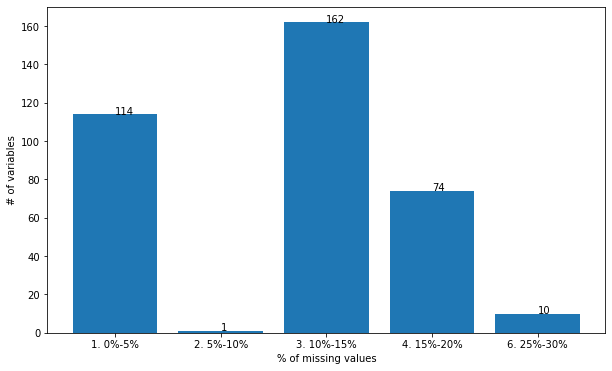

In [92]:
plt.figure(figsize = (10, 6))
plt.bar(x = a1['percent_miss1'], height = a1['number_of_variables'])
plt.ylabel('# of variables')
plt.xlabel('% of missing values')
for i, j in enumerate(a1['number_of_variables']):
    plt.text(i, j, str(j))

In [54]:
# So, we see that out of 361 variables, only 114 variables have less than 5% missing values

In [61]:
# Many variables have high percentage of missing values, and replacing the missing values with mean is taking too high a time
# and not converging with my laptop's memory resources, For the clustering exercise, 
# we'll take only those variables which have all values present
(a['percent_miss'] == 0).sum()

94

In [62]:
(a['percent_miss'] <= 0.01).sum()

113

In [63]:
model_vars = list(a[a['percent_miss'] == 0]['var'])

In [64]:
combs = comb[model_vars]
combs.shape

(1082873, 94)

In [65]:
combs.head(2)

,LNR,AGER_TYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,...,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,source
0,910215,-1,0,0,10,0,0,0,10,10,...,7,2,3,1,-1,-1,3,1,2,azdias
1,910220,-1,0,0,10,0,0,0,10,10,...,4,5,6,1,3,2,5,2,1,azdias


In [66]:
# Checking is a variable takes just single values for all customer ids
b = combs.nunique().reset_index()
b.columns = ['var', 'no_of_unique']

In [67]:
b.head(2)

,var,no_of_unique
0,LNR,1082873
1,AGER_TYP,5


In [68]:
b.sort_values(by = 'no_of_unique')

,var,no_of_unique
93,source,2
69,GREEN_AVANTGARDE,2
91,ANREDE_KZ,2
89,VERS_TYP,3
70,HEALTH_TYP,4
...,...,...
50,D19_VERSAND_OFFLINE_DATUM,10
23,D19_GESAMT_DATUM,10
73,PRAEGENDE_JUGENDJAHRE,16
68,GEBURTSJAHR,117


In [69]:
#So, no variable has same values across all rows

In [70]:
combs.head(2)

,LNR,AGER_TYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,...,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,source
0,910215,-1,0,0,10,0,0,0,10,10,...,7,2,3,1,-1,-1,3,1,2,azdias
1,910220,-1,0,0,10,0,0,0,10,10,...,4,5,6,1,3,2,5,2,1,azdias


In [71]:
combs.shape

(1082873, 94)

In [72]:
#LNR is the cusotmer id

In [73]:
combs.dtypes.unique()

array([dtype('int64'), dtype('O')], dtype=object)

In [74]:
# Using only numeric variables for clustering as KMeans requires the input variables to be numeric
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
combs_num = combs.select_dtypes(include = numerics)

In [75]:
combs_num.shape

(1082873, 93)

In [76]:
combs_num.head(2)

,LNR,AGER_TYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,...,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,0,0,10,0,0,0,10,10,...,4,7,2,3,1,-1,-1,3,1,2
1,910220,-1,0,0,10,0,0,0,10,10,...,6,4,5,6,1,3,2,5,2,1


In [77]:
# We should scale the values of variables to get good results

<AxesSubplot:>

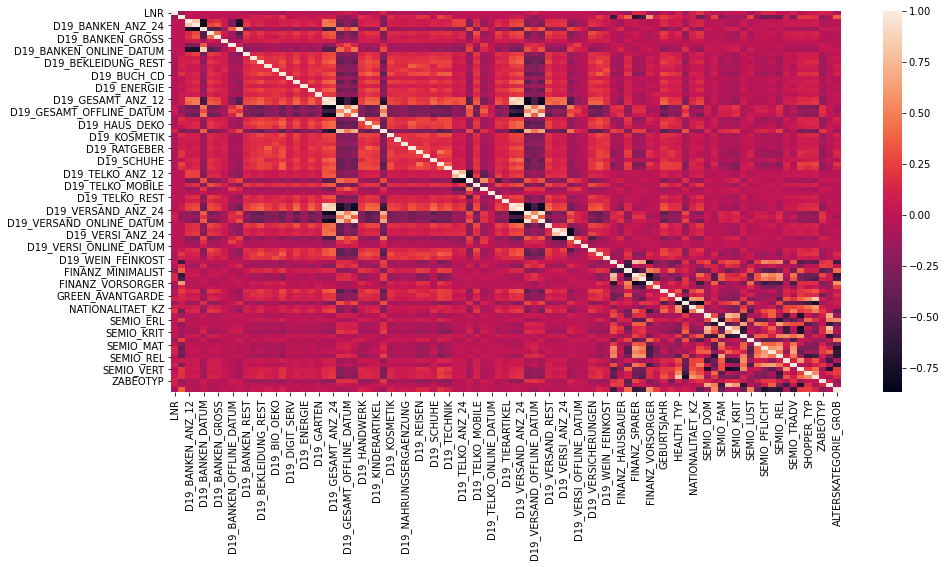

In [96]:
plt.figure(figsize = (15, 7))
sns.heatmap(combs_num.corr())

In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
combs_num.head(2)

,LNR,AGER_TYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,...,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,0,0,10,0,0,0,10,10,...,4,7,2,3,1,-1,-1,3,1,2
1,910220,-1,0,0,10,0,0,0,10,10,...,6,4,5,6,1,3,2,5,2,1


In [26]:
combs_num1 = combs_num.drop('LNR', axis = 1)
combs_num1.head(2)

,AGER_TYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,...,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-1,0,0,10,0,0,0,10,10,0,...,4,7,2,3,1,-1,-1,3,1,2
1,-1,0,0,10,0,0,0,10,10,0,...,6,4,5,6,1,3,2,5,2,1


In [27]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(combs_num1)

In [28]:
scaled.shape

(1082873, 92)

In [29]:
scaled

array([[0.        , 0.        , 0.        , ..., 0.4       , 0.        ,
        0.125     ],
       [0.        , 0.        , 0.        , ..., 0.8       , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.8       , 1.        ,
        0.25      ],
       ...,
       [0.75      , 0.        , 0.        , ..., 0.4       , 0.        ,
        0.375     ],
       [1.        , 0.16666667, 0.16666667, ..., 0.4       , 1.        ,
        0.25      ],
       [1.        , 0.16666667, 0.16666667, ..., 0.        , 0.        ,
        0.125     ]])

In [30]:
# Now, let's perform Principal Component Analysis (PCA) to reduce the number of variables going inside the KMeans algorithm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [31]:
pca = PCA()
pca.fit(scaled)

PCA()

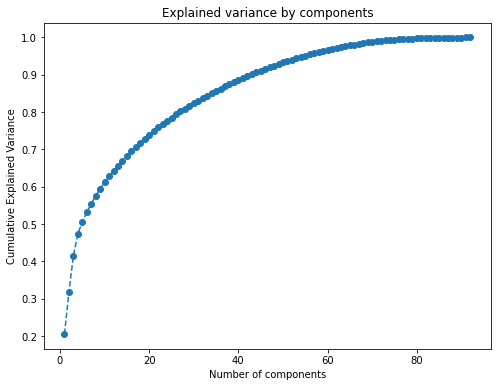

In [70]:
# Let's plot the cumulative variance explained by the principal components to determine a cutoff of the number of 
# principal components to be used in KMeans clustering
plt.figure(figsize = (8, 6))
plt.plot(range(1, 93), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained Variance');

In [170]:
# Let's take 40 components for clustering, as ~90% of the variance in the original variables is explained by 40 principal
# components

In [32]:
#Running PCA with 40 components
pca = PCA(n_components = 40)

In [33]:
pca.fit(scaled)
scaled_pca = pca.transform(scaled)

In [34]:
scaled_pca.shape

(1082873, 40)

In [80]:
# We need to determing the optimum number of clusters for the KMeans clustering
sse = []
for i in range(1, 21):
    model = KMeans(n_clusters = i, init = 'k-means++')
    model.fit(scaled_pca)
    sse.append(model.inertia_)

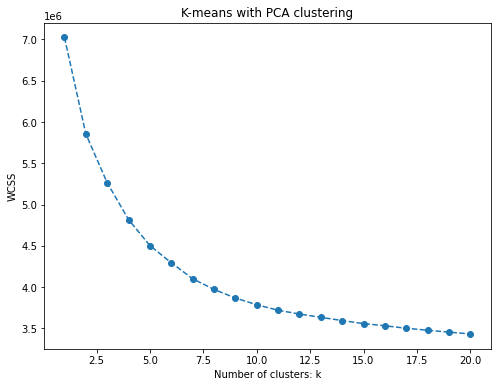

In [81]:
plt.figure(figsize = (8, 6))
plt.plot(range(1, 21), sse, marker = 'o', linestyle = '--')
plt.title('K-means with PCA clustering')
plt.xlabel('Number of clusters: k')
plt.ylabel('WCSS');

In [171]:
# It can be seen that as the number of clusters increase the Within Cluster Sum of Squares (WCSS) keeps on decreasing.
# From the above chart, we don't see a clear elbow in the curve. Hence, we can't determine the number of clusters
# just by this graph

In [35]:
# Let's calculate the silhouette score to determine the optimum number of KMeans clusters
from sklearn.metrics import silhouette_score

In [39]:
sc = []
sample_size = 100000
sample = pd.DataFrame(scaled_pca).sample(n = sample_size).values

for i in range(2, 22):
    model = KMeans(n_clusters = i)
    model.fit(sample)
    score = silhouette_score(sample, model.labels_)
    sc.append(score)

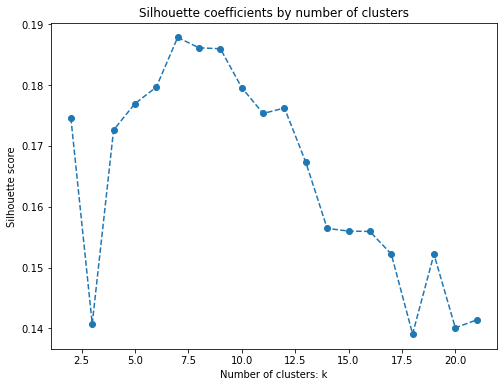

In [40]:
plt.figure(figsize = (8, 6))
plt.plot(range(2, 22), sc, marker = 'o', linestyle = '--')
plt.title('Silhouette coefficients by number of clusters')
plt.xlabel('Number of clusters: k')
plt.ylabel('Silhouette score');
# We can see the the Silhouette score is highest when n = 7. So, 7 is the right number of clusters

In [172]:
# Running KMeans using 7 as the desired number of output clusters

In [36]:
model = KMeans(n_clusters = 7, init = 'k-means++')
model.fit(scaled_pca)

KMeans(n_clusters=7)

In [37]:
model.labels_

array([1, 2, 2, ..., 0, 4, 5])

In [38]:
len(model.labels_)

1082873

In [39]:
scaled_pca.shape

(1082873, 40)

In [40]:
pd.DataFrame(scaled_pca)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-1.914281,0.268641,-0.030192,1.298237,-0.069343,0.040766,-0.153897,0.045562,0.095672,-0.054558,...,-0.087362,-0.063066,-0.032212,-0.008026,-0.113477,-0.015349,-0.036544,0.016017,0.077747,0.004472
1,-1.241219,0.931984,0.423721,-1.466413,0.238895,0.200253,-0.008318,-0.297375,-0.033034,-0.205959,...,-0.011449,-0.191870,0.024687,0.038082,-0.134266,-0.011873,-0.031655,0.074828,0.283596,0.029491
2,-0.212285,-0.068008,0.832597,-1.087750,1.162558,-0.051313,0.017065,-0.675928,0.249724,0.099424,...,0.363892,0.035010,-0.062766,0.071926,0.232538,0.064097,0.096068,-0.118660,-0.206679,-0.082914
3,0.184654,-1.194061,0.216465,-0.437426,0.787802,0.345431,-0.508166,0.298020,-0.250635,0.162860,...,-0.046635,0.039359,-0.141172,0.178403,0.172825,-0.029078,0.034791,-0.012978,-0.103938,-0.135891
4,2.495959,0.891714,-0.416974,0.294894,-1.276377,0.067226,0.155550,0.315274,0.515372,0.283635,...,0.454472,0.269714,-0.267765,0.228208,0.299385,0.673300,0.198979,-0.400986,0.193751,-0.430139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082868,0.402451,-0.898780,-0.974038,0.112624,0.013107,-0.656297,0.135997,-0.157802,-0.568487,0.675074,...,0.169763,0.213882,-0.087894,0.344571,-0.276861,0.260437,-0.233236,-0.410528,0.013427,0.493195
1082869,-0.526938,-1.272729,0.614245,-0.375979,-0.107965,-0.358887,0.489083,0.146413,0.420687,-0.110624,...,-0.060097,0.152262,-0.059474,-0.249496,-0.036145,0.032749,-0.075527,0.106928,0.165120,0.050577
1082870,0.766413,-1.514373,-0.616361,0.103810,0.384945,-0.131725,-0.551302,-0.477897,0.190009,-0.085222,...,0.015120,0.353068,0.235690,-0.125588,0.261751,0.340812,-0.070702,-0.164018,-0.061038,-0.444527
1082871,0.723543,-0.630037,1.081961,0.037563,0.225180,0.628628,0.824058,-0.006217,-0.081220,0.818077,...,0.094060,-0.060707,0.325531,-0.598693,0.082975,0.073381,0.111141,0.092518,-0.101012,-0.355150


In [41]:
x = pd.DataFrame(scaled_pca).loc[:,:1]
x.columns = ['pca1', 'pca2']
x.head(2)

,pca1,pca2
0,-1.914281,0.268641
1,-1.241219,0.931984


In [42]:
model.labels_

array([1, 2, 2, ..., 0, 4, 5])

In [43]:
x.head(3)

,pca1,pca2
0,-1.914281,0.268641
1,-1.241219,0.931984
2,-0.212285,-0.068008


In [44]:
pd.DataFrame(model.labels_)

,0
0,1
1,2
2,2
3,4
4,5
...,...
1082868,0
1082869,4
1082870,0
1082871,4


In [45]:
x1 = pd.concat([x, pd.DataFrame(model.labels_)], axis = 1)

In [46]:
x1.columns

Index(['pca1', 'pca2', 0], dtype='object')

In [47]:
x1 = x1.rename(columns = {0: 'label'})

In [48]:
x1.shape

(1082873, 3)

In [49]:
x1.head(3)

,pca1,pca2,label
0,-1.914281,0.268641,1
1,-1.241219,0.931984,2
2,-0.212285,-0.068008,2


In [50]:
x1.groupby('label').count()

,pca1,pca2
label,,
0,207039,207039
1,143106,143106
2,117592,117592
3,147511,147511
4,192393,192393
5,161008,161008
6,114224,114224


In [51]:
x1.shape

(1082873, 3)

In [52]:
sample_size = 1000
s = x1.sample(n = sample_size)

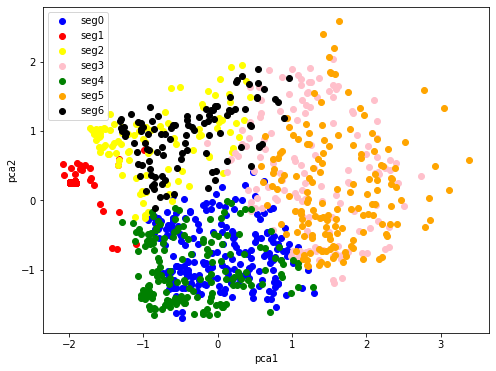

In [53]:
# Visualizing the 7 clusters using two principal components - pca1, and pca2 - on a 2-d graph
plt.figure(figsize = (8, 6))
plt.scatter(s[s['label'] == 0]['pca1'], s[s['label'] == 0]['pca2'], color = 'blue', label = 'seg0')
plt.scatter(s[s['label'] == 1]['pca1'], s[s['label'] == 1]['pca2'], color = 'red', label = 'seg1')
plt.scatter(s[s['label'] == 2]['pca1'], s[s['label'] == 2]['pca2'], color = 'yellow', label = 'seg2')
plt.scatter(s[s['label'] == 3]['pca1'], s[s['label'] == 3]['pca2'], color = 'pink', label = 'seg3')
plt.scatter(s[s['label'] == 4]['pca1'], s[s['label'] == 4]['pca2'], color = 'green', label = 'seg4')
plt.scatter(s[s['label'] == 5]['pca1'], s[s['label'] == 5]['pca2'], color = 'orange', label = 'seg5')
plt.scatter(s[s['label'] == 6]['pca1'], s[s['label'] == 6]['pca2'], color = 'black', label = 'seg6')
# plt.scatter(s[s['label'] == 7]['pca1'], s[s['label'] == 7]['pca2'], color = 'coral', label = 'seg7')
# plt.scatter(s[s['label'] == 8]['pca1'], s[s['label'] == 8]['pca2'], color = 'gray', label = 'seg8')
# plt.scatter(s[s['label'] == 9]['pca1'], s[s['label'] == 9]['pca2'], color = 'purple', label = 'seg9')
# plt.scatter(s[s['label'] == 10]['pca1'], s[s['label'] == 10]['pca2'], color = '#88c999', label = 'seg10')
# plt.scatter(s[s['label'] == 11]['pca1'], s[s['label'] == 11]['pca2'], color = 'beige', label = 'seg11')
# plt.scatter(s[s['label'] == 12]['pca1'], s[s['label'] == 12]['pca2'], color = 'brown', label = 'seg12')
# plt.scatter(s[s['label'] == 13]['pca1'], s[s['label'] == 13]['pca2'], color = 'cyan', label = 'seg13')
# plt.scatter(s[s['label'] == 14]['pca1'], s[s['label'] == 14]['pca2'], color = 'magenta', label = 'seg14')

plt.xlabel('pca1')
plt.ylabel('pca2')
plt.legend();

In [ ]:
# Now, let's analyze whether the 7 clusters are different from each other with respect to the distribution of 
# customers from Azdias and Customers datasets

In [54]:
comb.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,source
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2,azdias
1,910220,-1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,...,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1,azdias


In [56]:
comb['LNR'].max()

1082873

In [57]:
comb.tail(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,source
191650,148852,3,1.0,13.0,13.0,4.0,0.0,0.0,4.0,3.0,...,1.0,1.0,1.0,4.0,9.0,2.0,3,2,3,customers
191651,148883,3,1.0,0.0,9.0,1.0,0.0,0.0,3.0,1.0,...,1.0,1.0,1.0,3.0,9.0,7.0,1,1,2,customers


In [58]:
x2 = pd.concat([comb[['LNR', 'source']].reset_index(drop = True), x1], axis = 1)
x2.shape

(1082873, 5)

In [59]:
j = x2.groupby(['source', 'label']).count()['LNR'].reset_index()
type(j)

pandas.core.frame.DataFrame

In [60]:
pt = pd.pivot_table(j, index = ['source'], columns = ['label'], values = 'LNR').reset_index()
pt

label,source,0,1,2,3,4,5,6
0,azdias,166503,96065,116306,127179,166222,106826,112120
1,customers,40536,47041,1286,20332,26171,54182,2104


In [61]:
pt = pt.transpose().reset_index()
pt

,label,0,1
0,source,azdias,customers
1,0,166503,40536
2,1,96065,47041
3,2,116306,1286
4,3,127179,20332
5,4,166222,26171
6,5,106826,54182
7,6,112120,2104


In [62]:
pt.columns = ['label', 'azdias', 'customers']

In [63]:
pt = pt[1:]

In [64]:
pt['azdias_percent_dist'] = (pt['azdias']/pt['azdias'].sum())*100

<ipython-input-64-7e327b7b2e6f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pt['azdias_percent_dist'] = (pt['azdias']/pt['azdias'].sum())*100


In [65]:
pt['cust_percent_dist'] = (pt['customers']/pt['customers'].sum())*100

<ipython-input-65-8c1397620d45>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pt['cust_percent_dist'] = (pt['customers']/pt['customers'].sum())*100


In [66]:
pt['azdias_perentage_in_seg'] = (pt['azdias']/(pt['azdias']+pt['customers']))*100

<ipython-input-66-5420d1c12704>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pt['azdias_perentage_in_seg'] = (pt['azdias']/(pt['azdias']+pt['customers']))*100


In [67]:
pt

,label,azdias,customers,azdias_percent_dist,cust_percent_dist,azdias_perentage_in_seg
1,0,166503,40536,18.6826,21.1508,80.4211
2,1,96065,47041,10.779,24.545,67.1286
3,2,116306,1286,13.0502,0.671008,98.9064
4,3,127179,20332,14.2702,10.6088,86.2166
5,4,166222,26171,18.651,13.6555,86.3971
6,5,106826,54182,11.9865,28.271,66.3483
7,6,112120,2104,12.5805,1.09782,98.158


In [68]:
(x2.groupby("source").count()['LNR'][0]/x2.shape[0])

0.8230152566367431

In [69]:
pt['Azdias_proportion_index'] = pt['azdias_perentage_in_seg']/((x2.groupby("source").count()['LNR'][0]/x2.shape[0])*100)

<ipython-input-69-531b15ccb5a9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pt['Azdias_proportion_index'] = pt['azdias_perentage_in_seg']/((x2.groupby("source").count()['LNR'][0]/x2.shape[0])*100)


In [70]:
pt

,label,azdias,customers,azdias_percent_dist,cust_percent_dist,azdias_perentage_in_seg,Azdias_proportion_index
1,0,166503,40536,18.6826,21.1508,80.4211,0.977152
2,1,96065,47041,10.779,24.545,67.1286,0.815642
3,2,116306,1286,13.0502,0.671008,98.9064,1.20176
4,3,127179,20332,14.2702,10.6088,86.2166,1.04757
5,4,166222,26171,18.651,13.6555,86.3971,1.04976
6,5,106826,54182,11.9865,28.271,66.3483,0.806161
7,6,112120,2104,12.5805,1.09782,98.158,1.19266


In [71]:
# Overall "Azdias" proportion
(pt['azdias'].sum()/(pt['azdias'].sum()+pt['customers'].sum()))*100

82.30152566367431

In [69]:
# It can be seen that compared to overall user base, "Azdias" proportion is much higher in segments labeled 2, and 6
# and, much lower in segments labeled 1, and 5

In [70]:
# Also, the segments labeled 0, 3, 4 have the same proportion of "Azdias" as in the overall population

In [ ]:
# Further, it can be interpreted that since segments 2 and 6 are "Azdias" dominant, users belonging to them are 
# likely to be very different from users from "Customers"

In [ ]:
# While, since segments 1 and 5 are "Customers" dominant, users belonging to them are likely to be very similar to "Customers"
# type of users. Hence, we can interpret that "Azdias" users belonging to these segments are likely to be very similar to 
# 'Customers'

In [138]:
# Now, let's look at the characteristics of each of these segments

In [97]:
c = pd.concat([comb.reset_index(drop = True), x1['label']], axis = 1)

In [99]:
c['label'].isnull().sum()

0

In [100]:
c.shape

(1082873, 362)

In [101]:
c.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,source,label
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3,1,2,azdias,1
1,910220,-1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,...,11.0,10.0,3.0,9.0,4.0,5,2,1,azdias,2


In [102]:
c.tail(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,source,label
1082871,148852,3,1.0,13.0,13.0,4.0,0.0,0.0,4.0,3.0,...,1.0,1.0,4.0,9.0,2.0,3,2,3,customers,4
1082872,148883,3,1.0,0.0,9.0,1.0,0.0,0.0,3.0,1.0,...,1.0,1.0,3.0,9.0,7.0,1,1,2,customers,5


In [106]:
# Now, let's look at the average characteristics of the users in each of the 7 segments

In [112]:
m = pd.DataFrame(c.isnull().sum()/c.shape[0]).reset_index()
m.columns = ['var', 'miss_perc']

In [114]:
# Only analyzing variables with less than 1% values as missing
list1 = m[(m['miss_perc'] < 0.01)]['var']

In [115]:
len(list1)

114

In [116]:
c = c[list1]

In [117]:
c.shape

(1082873, 114)

In [118]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
c_num = c.select_dtypes(include = numerics)

In [119]:
c_num.shape

(1082873, 113)

In [120]:
set(c.columns).difference(set(c_num.columns))

{'source'}

In [121]:
# So, all these varaibles are numeric variables

In [122]:
# Replacing missing values with mean
c.head(2)

,LNR,AGER_TYP,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,source,label
0,910215,-1,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,...,2,3,1,-1,-1,3,1,2,azdias,1
1,910220,-1,5.0,1.0,5.0,5.0,2.0,3.0,1.0,1.0,...,5,6,1,3,2,5,2,1,azdias,2


In [123]:
c = c.fillna(c.mean())

In [124]:
c.isnull().sum().sum()

0

In [125]:
c.head(2)

,LNR,AGER_TYP,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,source,label
0,910215,-1,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,...,2,3,1,-1,-1,3,1,2,azdias,1
1,910220,-1,5.0,1.0,5.0,5.0,2.0,3.0,1.0,1.0,...,5,6,1,3,2,5,2,1,azdias,2


In [127]:
g = c.groupby('label').mean().reset_index()

In [133]:
g1 = g.transpose()

In [136]:
overall_mean = c.mean()

In [138]:
g1.head(3)

,0,1,2,3,4,5,6
label,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000
LNR,529524.686388,474320.593525,633829.058057,561014.957644,558360.913760,459031.620801,614367.607543
AGER_TYP,0.247692,-0.996716,-0.965695,-0.195674,0.317018,0.204307,-0.994178


In [151]:
g1 = g1[2:]

In [144]:
om = pd.DataFrame(overall_mean).reset_index()
om.columns = ['var', 'overall_mean']

,var,overall_mean
0,LNR,541437.000000
1,AGER_TYP,-0.234051
2,CJT_GESAMTTYP,3.640744
3,CJT_KATALOGNUTZER,3.453551
4,CJT_TYP_1,3.244895
...,...,...
108,VERS_TYP,1.136112
109,ZABEOTYP,3.223393
110,ANREDE_KZ,1.496318
111,ALTERSKATEGORIE_GROB,2.827574


In [158]:
om = om[1:][:-1]

In [162]:
g1 = g1.reset_index()

In [163]:
g1

,index,0,1,2,3,4,5,6
0,AGER_TYP,0.247692,-0.996716,-0.965695,-0.195674,0.317018,0.204307,-0.994178
1,CJT_GESAMTTYP,2.919612,5.208389,3.961850,3.828189,2.690701,3.639448,4.013196
2,CJT_KATALOGNUTZER,4.381888,4.541693,1.790909,1.976403,3.802011,3.197865,3.800353
3,CJT_TYP_1,1.961858,4.473239,4.716574,3.561906,2.568397,2.528880,4.255830
4,CJT_TYP_2,2.062836,4.407743,4.466558,3.114417,2.099962,2.442030,4.354088
...,...,...,...,...,...,...,...,...
106,SHOPPER_TYP,1.458083,-1.000000,1.697173,1.949299,1.898629,1.265707,0.906027
107,VERS_TYP,1.506904,-1.000000,1.372678,1.345066,1.522160,1.521980,1.432720
108,ZABEOTYP,3.209077,3.098759,4.345814,3.119496,3.147162,2.271850,3.853822
109,ANREDE_KZ,1.000299,1.560249,1.999889,1.997932,2.000000,1.000199,1.000018


In [169]:
om = om.reset_index(drop = True)

In [171]:
g2 = pd.concat([g1, om['overall_mean']], axis = 1)

In [172]:
g2.shape

(111, 9)

In [173]:
g2.head(3)

,index,0,1,2,3,4,5,6,overall_mean
0,AGER_TYP,0.247692,-0.996716,-0.965695,-0.195674,0.317018,0.204307,-0.994178,-0.234051
1,CJT_GESAMTTYP,2.919612,5.208389,3.961850,3.828189,2.690701,3.639448,4.013196,3.640744
2,CJT_KATALOGNUTZER,4.381888,4.541693,1.790909,1.976403,3.802011,3.197865,3.800353,3.453551


In [175]:
g2 = g2.rename(columns = {'index': 'var'})

In [176]:
g2.head(2)

,var,0,1,2,3,4,5,6,overall_mean
0,AGER_TYP,0.247692,-0.996716,-0.965695,-0.195674,0.317018,0.204307,-0.994178,-0.234051
1,CJT_GESAMTTYP,2.919612,5.208389,3.961850,3.828189,2.690701,3.639448,4.013196,3.640744


In [ ]:
# Let's create index with respect to each of the 7 segments to know how much are the variable values are higher or lower in comparison
# to the overall customers
g2['index_0'] = g2[0]/g2['overall_mean']
g2['index_1'] = g2[1]/g2['overall_mean']
g2['index_2'] = g2[2]/g2['overall_mean']
g2['index_3'] = g2[3]/g2['overall_mean']
g2['index_4'] = g2[4]/g2['overall_mean']
g2['index_5'] = g2[5]/g2['overall_mean']
g2['index_6'] = g2[6]/g2['overall_mean']

In [181]:
g2.head(4)

,var,0,1,2,3,4,5,6,overall_mean,index_0,index_1,index_2,index_3,index_4,index_5,index_6
0,AGER_TYP,0.247692,-0.996716,-0.965695,-0.195674,0.317018,0.204307,-0.994178,-0.234051,-1.058282,4.258532,4.125994,0.836028,-1.354479,-0.872913,4.247690
1,CJT_GESAMTTYP,2.919612,5.208389,3.961850,3.828189,2.690701,3.639448,4.013196,3.640744,0.801928,1.430584,1.088198,1.051485,0.739053,0.999644,1.102301
2,CJT_KATALOGNUTZER,4.381888,4.541693,1.790909,1.976403,3.802011,3.197865,3.800353,3.453551,1.268807,1.315079,0.518570,0.572282,1.100899,0.925964,1.100419
3,CJT_TYP_1,1.961858,4.473239,4.716574,3.561906,2.568397,2.528880,4.255830,3.244895,0.604598,1.378546,1.453537,1.097695,0.791519,0.779341,1.311546


In [187]:
g2['max_index'] = g2[['index_0', 'index_1', 'index_2', 'index_3', 'index_4', 'index_5', 'index_6']].max(axis = 1)

In [188]:
g2.head(3)

,var,0,1,2,3,4,5,6,overall_mean,index_0,index_1,index_2,index_3,index_4,index_5,index_6,max_index
0,AGER_TYP,0.247692,-0.996716,-0.965695,-0.195674,0.317018,0.204307,-0.994178,-0.234051,-1.058282,4.258532,4.125994,0.836028,-1.354479,-0.872913,4.247690,4.258532
1,CJT_GESAMTTYP,2.919612,5.208389,3.961850,3.828189,2.690701,3.639448,4.013196,3.640744,0.801928,1.430584,1.088198,1.051485,0.739053,0.999644,1.102301,1.430584
2,CJT_KATALOGNUTZER,4.381888,4.541693,1.790909,1.976403,3.802011,3.197865,3.800353,3.453551,1.268807,1.315079,0.518570,0.572282,1.100899,0.925964,1.100419,1.315079


In [191]:
# Let's look at the top 10 variables which are most differentiating between segments based on the index values
g2 = g2.sort_values('max_index', ascending = False)
g2.head(10)

,var,0,1,2,3,4,5,6,overall_mean,index_0,index_1,index_2,index_3,index_4,index_5,index_6,max_index
0,AGER_TYP,0.247692,-0.996716,-0.965695,-0.195674,0.317018,0.204307,-0.994178,-0.234051,-1.058282,4.258532,4.125994,0.836028,-1.354479,-0.872913,4.247690,4.258532
54,D19_VERSAND_ANZ_12,0.094697,0.010768,0.182300,2.044505,0.112951,1.804426,0.264936,0.634138,0.149332,0.016981,0.287477,3.224069,0.178118,2.845478,0.417788,3.224069
55,D19_VERSAND_ANZ_24,0.228759,0.020558,0.393649,3.025002,0.260727,2.700176,0.507976,1.002657,0.228153,0.020504,0.392606,3.016986,0.260036,2.693022,0.506630,3.016986
28,D19_GESAMT_ANZ_12,0.194422,0.017735,0.276405,2.449621,0.187164,2.257844,0.476607,0.822460,0.236391,0.021563,0.336071,2.978406,0.227566,2.745232,0.579490,2.978406
53,D19_TIERARTIKEL,0.060114,0.004815,0.154509,0.711994,0.076541,0.599268,0.123223,0.241597,0.248820,0.019928,0.639531,2.947032,0.316814,2.480445,0.510034,2.947032
43,D19_SCHUHE,0.114645,0.013053,0.386268,1.532150,0.171768,1.271123,0.308762,0.526388,0.217796,0.024798,0.733809,2.910688,0.326315,2.414804,0.586567,2.910688
24,D19_DROGERIEARTIKEL,0.168582,0.015171,0.445932,1.986089,0.217030,1.739143,0.359565,0.688284,0.244931,0.022041,0.647889,2.885567,0.315320,2.526782,0.522409,2.885567
38,D19_LEBENSMITTEL,0.154198,0.008819,0.091180,0.899180,0.173114,1.047699,0.148218,0.365206,0.422222,0.024147,0.249666,2.462117,0.474018,2.868788,0.405846,2.868788
21,D19_BIO_OEKO,0.125527,0.006163,0.069690,0.789277,0.168436,0.875708,0.071684,0.307592,0.408096,0.020037,0.226567,2.565986,0.547597,2.846980,0.233048,2.846980
9,D19_BANKEN_ANZ_12,0.023189,0.002893,0.038931,0.325054,0.017152,0.330437,0.107079,0.116797,0.198540,0.024769,0.333325,2.783073,0.146857,2.829164,0.916799,2.829164


In [193]:
c.head(2)

,LNR,AGER_TYP,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,source,label
0,910215,-1,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,...,2,3,1,-1,-1,3,1,2,azdias,1
1,910220,-1,5.0,1.0,5.0,5.0,2.0,3.0,1.0,1.0,...,5,6,1,3,2,5,2,1,azdias,2


In [194]:
c.shape

(1082873, 114)

In [218]:
means = c.groupby('source').mean().reset_index().transpose().reset_index()
means.columns = ['var', 'azdias_mean', 'customers_mean']

In [219]:
means = means[2:][:-1]

In [226]:
means = means.reset_index(drop = True)

,var,azdias_mean,customers_mean
0,AGER_TYP,-0.358435,0.344359
1,CJT_GESAMTTYP,3.63288,3.6773
2,CJT_KATALOGNUTZER,3.33591,4.00061


In [238]:
g2 = g2.merge(means, left_on = 'var', right_on = "var", how = "left")

In [239]:
g2.head(4)

,var,0,1,2,3,4,5,6,overall_mean,index_0,index_1,index_2,index_3,index_4,index_5,index_6,max_index,azdias_mean,customers_mean
0,AGER_TYP,0.247692,-0.996716,-0.965695,-0.195674,0.317018,0.204307,-0.994178,-0.234051,-1.058282,4.258532,4.125994,0.836028,-1.354479,-0.872913,4.247690,4.258532,-0.358435,0.344359
1,D19_VERSAND_ANZ_12,0.094697,0.010768,0.182300,2.044505,0.112951,1.804426,0.264936,0.634138,0.149332,0.016981,0.287477,3.224069,0.178118,2.845478,0.417788,3.224069,0.604646,0.771283
2,D19_VERSAND_ANZ_24,0.228759,0.020558,0.393649,3.025002,0.260727,2.700176,0.507976,1.002657,0.228153,0.020504,0.392606,3.016986,0.260036,2.693022,0.506630,3.016986,0.958868,1.20629
3,D19_GESAMT_ANZ_12,0.194422,0.017735,0.276405,2.449621,0.187164,2.257844,0.476607,0.822460,0.236391,0.021563,0.336071,2.978406,0.227566,2.745232,0.579490,2.978406,0.797683,0.937679


In [378]:
# AGER_TYP comes out to be a top significant variable. But let's check the values it takes
(c['AGER_TYP'] == -1).sum()/c.shape[0]

0.710711228371194

In [173]:
# So, 71% of the values in AGER_TYP are unknown. So, let's not consider this, and let's look at the other remaining variables

In [380]:
g2_10 = g2[1:11]

In [381]:
g2_10

,var,0,1,2,3,4,5,6,overall_mean,index_0,index_1,index_2,index_3,index_4,index_5,index_6,max_index,azdias_mean,customers_mean
1,D19_VERSAND_ANZ_12,0.094697,0.010768,0.182300,2.044505,0.112951,1.804426,0.264936,0.634138,0.149332,0.016981,0.287477,3.224069,0.178118,2.845478,0.417788,3.224069,0.604646,0.771283
2,D19_VERSAND_ANZ_24,0.228759,0.020558,0.393649,3.025002,0.260727,2.700176,0.507976,1.002657,0.228153,0.020504,0.392606,3.016986,0.260036,2.693022,0.506630,3.016986,0.958868,1.20629
3,D19_GESAMT_ANZ_12,0.194422,0.017735,0.276405,2.449621,0.187164,2.257844,0.476607,0.822460,0.236391,0.021563,0.336071,2.978406,0.227566,2.745232,0.579490,2.978406,0.797683,0.937679
4,D19_TIERARTIKEL,0.060114,0.004815,0.154509,0.711994,0.076541,0.599268,0.123223,0.241597,0.248820,0.019928,0.639531,2.947032,0.316814,2.480445,0.510034,2.947032,0.243178,0.234247
5,D19_SCHUHE,0.114645,0.013053,0.386268,1.532150,0.171768,1.271123,0.308762,0.526388,0.217796,0.024798,0.733809,2.910688,0.326315,2.414804,0.586567,2.910688,0.510818,0.598788
6,D19_DROGERIEARTIKEL,0.168582,0.015171,0.445932,1.986089,0.217030,1.739143,0.359565,0.688284,0.244931,0.022041,0.647889,2.885567,0.315320,2.526782,0.522409,2.885567,0.673292,0.757999
7,D19_LEBENSMITTEL,0.154198,0.008819,0.091180,0.899180,0.173114,1.047699,0.148218,0.365206,0.422222,0.024147,0.249666,2.462117,0.474018,2.868788,0.405846,2.868788,0.319525,0.577636
8,D19_BIO_OEKO,0.125527,0.006163,0.069690,0.789277,0.168436,0.875708,0.071684,0.307592,0.408096,0.020037,0.226567,2.565986,0.547597,2.846980,0.233048,2.846980,0.257938,0.538492
9,D19_BANKEN_ANZ_12,0.023189,0.002893,0.038931,0.325054,0.017152,0.330437,0.107079,0.116797,0.198540,0.024769,0.333325,2.783073,0.146857,2.829164,0.916799,2.829164,0.122336,0.09104
10,D19_FREIZEIT,0.145127,0.011949,0.342966,1.687332,0.118882,1.656818,0.417959,0.607976,0.238705,0.019654,0.564110,2.775325,0.195537,2.725137,0.687460,2.775325,0.590678,0.688414


In [382]:
g2_10

,var,0,1,2,3,4,5,6,overall_mean,index_0,index_1,index_2,index_3,index_4,index_5,index_6,max_index,azdias_mean,customers_mean
1,D19_VERSAND_ANZ_12,0.094697,0.010768,0.182300,2.044505,0.112951,1.804426,0.264936,0.634138,0.149332,0.016981,0.287477,3.224069,0.178118,2.845478,0.417788,3.224069,0.604646,0.771283
2,D19_VERSAND_ANZ_24,0.228759,0.020558,0.393649,3.025002,0.260727,2.700176,0.507976,1.002657,0.228153,0.020504,0.392606,3.016986,0.260036,2.693022,0.506630,3.016986,0.958868,1.20629
3,D19_GESAMT_ANZ_12,0.194422,0.017735,0.276405,2.449621,0.187164,2.257844,0.476607,0.822460,0.236391,0.021563,0.336071,2.978406,0.227566,2.745232,0.579490,2.978406,0.797683,0.937679
4,D19_TIERARTIKEL,0.060114,0.004815,0.154509,0.711994,0.076541,0.599268,0.123223,0.241597,0.248820,0.019928,0.639531,2.947032,0.316814,2.480445,0.510034,2.947032,0.243178,0.234247
5,D19_SCHUHE,0.114645,0.013053,0.386268,1.532150,0.171768,1.271123,0.308762,0.526388,0.217796,0.024798,0.733809,2.910688,0.326315,2.414804,0.586567,2.910688,0.510818,0.598788
6,D19_DROGERIEARTIKEL,0.168582,0.015171,0.445932,1.986089,0.217030,1.739143,0.359565,0.688284,0.244931,0.022041,0.647889,2.885567,0.315320,2.526782,0.522409,2.885567,0.673292,0.757999
7,D19_LEBENSMITTEL,0.154198,0.008819,0.091180,0.899180,0.173114,1.047699,0.148218,0.365206,0.422222,0.024147,0.249666,2.462117,0.474018,2.868788,0.405846,2.868788,0.319525,0.577636
8,D19_BIO_OEKO,0.125527,0.006163,0.069690,0.789277,0.168436,0.875708,0.071684,0.307592,0.408096,0.020037,0.226567,2.565986,0.547597,2.846980,0.233048,2.846980,0.257938,0.538492
9,D19_BANKEN_ANZ_12,0.023189,0.002893,0.038931,0.325054,0.017152,0.330437,0.107079,0.116797,0.198540,0.024769,0.333325,2.783073,0.146857,2.829164,0.916799,2.829164,0.122336,0.09104
10,D19_FREIZEIT,0.145127,0.011949,0.342966,1.687332,0.118882,1.656818,0.417959,0.607976,0.238705,0.019654,0.564110,2.775325,0.195537,2.725137,0.687460,2.775325,0.590678,0.688414


In [401]:
# Based on these above variable index, the following can be interpreted
# Segment profiles:
#     Segment 0:
#         No transaction known or very low mail-order transactions in last 12 months
#         No transaction known or very low mail-order transactions in last 24 months
#         No or very low "Total Pool" transactions in last 12 months
#         No or very low "Animal Products" transactions
#         No or very low "Shoes" transactionns
#         No or very low "Drugstores" transactions
#         No or very low "Food Products" transactions 
#         No or very low "Ecologicals" transactions 
#         No or very low "Banks" transactions in last 12 months
#         No or very low "Leisure Products" transactions
        
#     Segment 1:
#         No transaction known or extremely low mail-order transactions in last 12 months
#         No transaction known or extremely low mail-order transactions in last 24 months
#         No or extremely low "Total Pool" transactions in last 12 months
#         No or extremely low "Animal Products" transactions
#         No or extremely low "Shoes" transactionns
#         No or extremely low "Drugstores" transactions
#         No or extremely low "Food Products" transactions 
#         No or extremely low "Ecologicals" transactions 
#         No or extremely low "Banks" transactions in last 12 months
#         No or extremely low "Leisure Products" transactions
        
#     Segment 2:
#         No transaction known or very low mail-order transactions in last 12 months
#         No transaction known or very low mail-order transactions in last 24 months
#         No or very low "Total Pool" transactions in last 12 months
#         No or very low "Animal Products" transactions
#         No or very low "Shoes" transactionns
#         No or very low "Drugstores" transactions
#         No or very low "Food Products" transactions 
#         No or very low "Ecologicals" transactions 
#         No or very low "Banks" transactions in last 12 months
#         No or very low "Leisure Products" transactions
        
#     Segment 3:
#         Very high "mail-order" transactions in last 12 months
#         Very high "mail-order" transactions in last 24 months
#         Very high "Total Pool" transactions in last 12 months
#         Very high "Animal Products" transactions
#         Very high "Shoes" transactionns
#         Very high "Drugstores" transactions
#         Very high "Food Products" transactions 
#         Very high "Ecologicals" transactions 
#         Very high "Banks" transactions in last 12 months
#         Very high "Leisure Products" transactions
        
#     Segment 4:
#         No transaction known or very low mail-order transactions in last 12 months
#         No transaction known or very low mail-order transactions in last 24 months
#         No or very low "Total Pool" transactions in last 12 months
#         No or very low "Animal Products" transactions
#         No or very low "Shoes" transactionns
#         No or very low "Drugstores" transactions
#         No or very low "Food Products" transactions 
#         No or very low "Ecologicals" transactions 
#         No or very low "Banks" transactions in last 12 months
#         No or very low "Leisure Products" transactions
        
#     Segment 5:
#         Very high "mail-order" transactions in last 12 months
#         Very high "mail-order" transactions in last 24 months
#         Very high "Total Pool" transactions in last 12 months
#         Very high "Animal Products" transactions
#         Very high "Shoes" transactionns
#         Very high "Drugstores" transactions
#         Very high "Food Products" transactions 
#         Very high "Ecologicals" transactions 
#         Very high "Banks" transactions in last 12 months
#         Very high "Leisure Products" transactions
        
#     Segment 6:
#         No transaction known or low mail-order transactions in last 12 months
#         No transaction known or low mail-order transactions in last 24 months
#         No or low "Total Pool" transactions in last 12 months
#         No or low "Animal Products" transactions
#         No or low "Shoes" transactionns
#         No or low "Drugstores" transactions
#         No or low "Food Products" transactions 
#         No or low "Ecologicals" transactions 
#         No or low "Banks" transactions in last 12 months
#         No or low "Leisure Products" transactions  

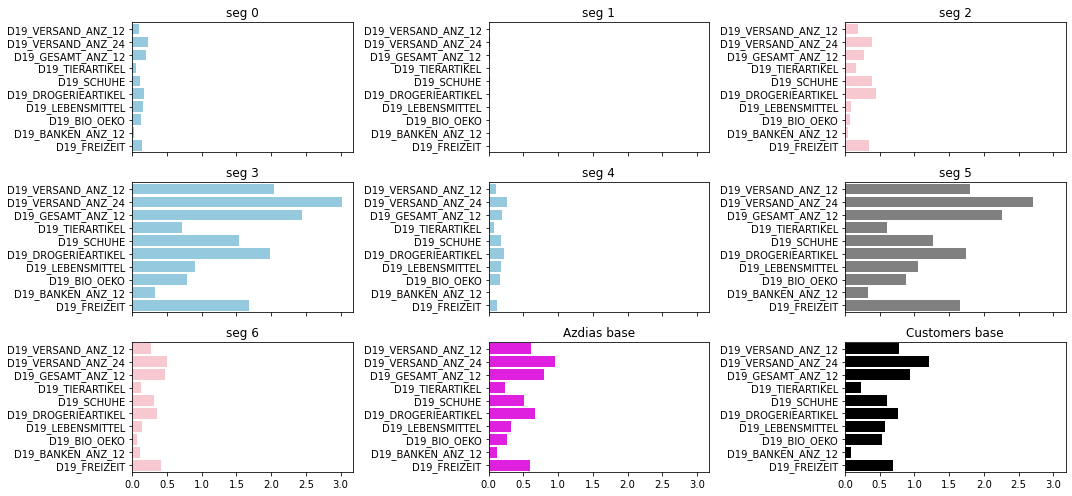

In [408]:
# Let's compare these 7 segments with respect to these above variables. We will keep the scale to be same for each segment's plot
# so that the values can be compared between them
fig, ax = plt.subplots(3, 3, figsize = (15, 7), sharex = True)
a = sns.barplot(x = g2_10[0], y = g2_10['var'], color = 'skyblue', ax = ax[0, 0])
a.set(ylabel = None)
a.set(xlabel = None)
a.set(title = 'seg 0')
a = sns.barplot(x = g2_10[1], y = g2_10['var'], color = 'grey', ax = ax[0, 1])
a.set(ylabel = None)
a.set(xlabel = None)
a.set(title = 'seg 1')
a = sns.barplot(x = g2_10[2], y = g2_10['var'], color = 'pink', ax = ax[0, 2])
a.set(ylabel = None)
a.set(xlabel = None)
a.set(title = 'seg 2')
a = sns.barplot(x = g2_10[3], y = g2_10['var'], color = 'skyblue', ax = ax[1, 0])
a.set(ylabel = None)
a.set(xlabel = None)
a.set(title = 'seg 3')
a = sns.barplot(x = g2_10[4], y = g2_10['var'], color = 'skyblue', ax = ax[1, 1])
a.set(ylabel = None)
a.set(xlabel = None)
a.set(title = 'seg 4')
a = sns.barplot(x = g2_10[5], y = g2_10['var'], color = 'grey', ax = ax[1, 2])
a.set(ylabel = None)
a.set(xlabel = None)
a.set(title = 'seg 5')
a = sns.barplot(x = g2_10[6], y = g2_10['var'], color = 'pink', ax = ax[2, 0])
a.set(ylabel = None)
a.set(xlabel = None)
a.set(title = 'seg 6')
a = sns.barplot(x = g2_10['azdias_mean'], y = g2_10['var'], color = 'magenta', ax = ax[2, 1])
a.set(ylabel = None)
a.set(xlabel = None)
a.set(title = 'Azdias base')
a = sns.barplot(x = g2_10['customers_mean'], y = g2_10['var'], color = 'black', ax = ax[2, 2])
a.set(ylabel = None)
a.set(xlabel = None)
a.set(title = 'Customers base')
fig.tight_layout();

In [400]:
pt

,label,azdias,customers,azdias_percent_dist,cust_percent_dist,azdias_perentage_in_seg,Azdias_proportion_index
1,0,166503,40536,18.6826,21.1508,80.4211,0.977152
2,1,96065,47041,10.779,24.545,67.1286,0.815642
3,2,116306,1286,13.0502,0.671008,98.9064,1.20176
4,3,127179,20332,14.2702,10.6088,86.2166,1.04757
5,4,166222,26171,18.651,13.6555,86.3971,1.04976
6,5,106826,54182,11.9865,28.271,66.3483,0.806161
7,6,112120,2104,12.5805,1.09782,98.158,1.19266


In [65]:
# Let's now look at the differentiating charateristics of the Overall population and the customer base of the company
# This will help us in knowing these things:
#     1. What is the profile of a typical customer of the company
#     2. What is the profile of a typical German consumer as present in the Azdias data
#     3. How are the two populations different from each other

In [5]:
comb.shape

(1082873, 361)

In [423]:
# Deleting objects which are not required now to release memory
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars and sys.getsizeof(globals().get(x)) > 100000], key=lambda x: x[1], reverse=True)

[('c', 1043381799), ('train', 137999602)]

In [425]:
del train

In [5]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
comb_num = comb.select_dtypes(include = numerics)

In [6]:
comb.shape

(1082873, 361)

In [7]:
comb_num.shape

(1082873, 354)

In [8]:
# So, most of the variables are numeric

In [9]:
num_cols = list(comb_num.columns)

In [10]:
cols_all = list(comb.columns)

In [11]:
cols_char = list(set(cols_all).difference(set(num_cols)))

In [12]:
comb_char = comb[cols_char]

In [13]:
comb_num.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1


In [14]:
# Let's check the mean values for each numeric variables for the two sets of dataset, and then see which variables
# over or under index between the two populations - customers, and German population

In [15]:
per_miss = pd.DataFrame(comb_num.isnull().sum()/comb_num.shape[0]).reset_index()

In [16]:
per_miss.columns = ['var', 'per_miss']
per_miss.head(2)

,var,per_miss
0,LNR,0.0
1,AGER_TYP,0.0


In [17]:
(per_miss['per_miss'] < 0.1).sum()

114

In [18]:
# Let's take only those variables which don't have more than 10% values as missing

In [19]:
a = list(per_miss[per_miss['per_miss'] < 0.1]['var'])
len(a)

114

In [20]:
b = comb_num[a]

In [21]:
b.shape

(1082873, 114)

In [22]:
b.head(2)

,LNR,AGER_TYP,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,...,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,...,4,7,2,3,1,-1,-1,3,1,2
1,910220,-1,5.0,1.0,5.0,5.0,2.0,3.0,1.0,1.0,...,6,4,5,6,1,3,2,5,2,1


In [23]:
b.fillna(b.mean()).isnull().sum().sum()

0

In [24]:
b1 = b.fillna(b.mean())
b1.head(2)

,LNR,AGER_TYP,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,...,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,...,4,7,2,3,1,-1,-1,3,1,2
1,910220,-1,5.0,1.0,5.0,5.0,2.0,3.0,1.0,1.0,...,6,4,5,6,1,3,2,5,2,1


In [165]:
comb_char.head(2)

,OST_WEST_KZ,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,source,CAMEO_DEUG_2015,EINGEFUEGT_AM,CAMEO_DEU_2015
0,NaN,NaN,NaN,azdias,NaN,NaN,NaN
1,W,51,NaN,azdias,8,1992-02-10 00:00:00,8A


In [26]:
# Adding source column to the numeric dataframe

In [27]:
b1.shape

(1082873, 114)

In [28]:
comb_char.shape

(1082873, 7)

In [29]:
b2 = pd.concat([b1, pd.DataFrame(comb_char['source'])], axis = 1)

In [30]:
b2.shape

(1082873, 115)

In [31]:
b2.head(2)

,LNR,AGER_TYP,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,...,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,source
0,910215,-1,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,...,7,2,3,1,-1,-1,3,1,2,azdias
1,910220,-1,5.0,1.0,5.0,5.0,2.0,3.0,1.0,1.0,...,4,5,6,1,3,2,5,2,1,azdias


In [47]:
list1 = list(b2.columns)
list1.remove('LNR')
list1.remove('source')
list1.remove('AGER_TYP')

In [48]:
f = b2[['AGER_TYP', 'source']].groupby('source').mean().reset_index()

In [49]:
for i in list1:
    k = b2[[i, 'source']].groupby('source').mean().reset_index()
    f = f.merge(k, left_on = 'source', right_on = 'source', how = 'left')

In [50]:
f.shape

(2, 114)

In [51]:
f.head(2)

,source,AGER_TYP,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,...,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,azdias,-0.358435,3.632881,3.335908,3.367415,3.194397,3.352403,3.337181,3.361791,3.467004,...,3.910139,4.240609,3.945860,3.661784,4.023709,1.266967,1.197852,3.362438,1.522098,2.777398
1,customers,0.344359,3.677304,4.000612,2.675155,2.557429,4.500261,4.400397,4.503929,4.524005,...,3.165879,4.112788,3.742137,2.919161,4.185279,0.987754,0.849008,2.576806,1.376432,3.060907


In [84]:
ft = f.transpose()
ft = ft.reset_index()
ft.columns = ['var', 'azdias', 'customers']

In [85]:
ft.shape

(114, 3)

In [86]:
ft.head(2)

,var,azdias,customers
0,source,azdias,customers
1,AGER_TYP,-0.358435,0.344359


In [87]:
ft.head(2)

,var,azdias,customers
0,source,azdias,customers
1,AGER_TYP,-0.358435,0.344359


In [88]:
ft = ft.iloc[1:]

In [89]:
ft.shape

(113, 3)

In [90]:
ft.head(2)

,var,azdias,customers
1,AGER_TYP,-0.358435,0.344359
2,CJT_GESAMTTYP,3.63288,3.6773


In [91]:
ft['ratio'] = ft['azdias']/ft['customers']

In [92]:
ft.head(2)

,var,azdias,customers,ratio
1,AGER_TYP,-0.358435,0.344359,-1.04088
2,CJT_GESAMTTYP,3.63288,3.6773,0.98792


In [93]:
ft.sort_values('ratio')

,var,azdias,customers,ratio
1,AGER_TYP,-0.358435,0.344359,-1.04088
43,D19_SAMMELARTIKEL,0.594606,1.43218,0.415175
19,D19_BEKLEIDUNG_GEH,0.467869,0.978727,0.478039
22,D19_BIO_OEKO,0.257938,0.538492,0.479001
68,D19_WEIN_FEINKOST,0.377515,0.788126,0.479003
...,...,...,...,...
37,D19_KONSUMTYP_MAX,5.84923,4.22447,1.38461
110,VERS_TYP,1.19785,0.849008,1.41089
80,HH_EINKOMMEN_SCORE,4.20262,2.95859,1.42048
79,HEALTH_TYP,1.7921,1.1984,1.49542


In [131]:
# Let's see on which parameters the overall population and the company's customers are similar
# This will be the case when the ratio is close to 1
ft_same = ft[(ft['ratio'] >= 0.97) & (ft['ratio'] <= 1.03)]
ft_same.head(2)

,var,azdias,customers,ratio
2,CJT_GESAMTTYP,3.63288,3.6773,0.98792
12,D19_BANKEN_DATUM,9.26742,9.3676,0.989306


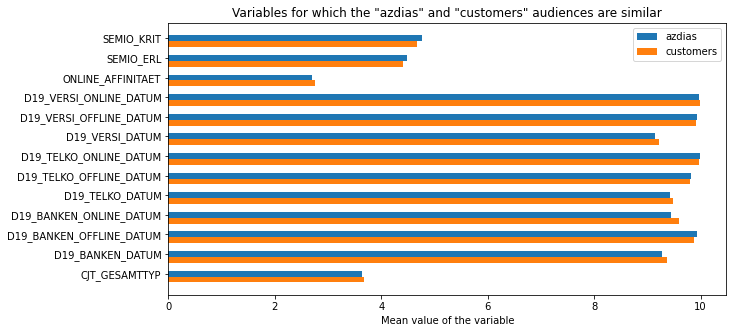

In [147]:
plt.figure(figsize = (10, 5))
plt.barh(y = np.arange(ft_same.shape[0]), width = ft_same['azdias'], height = 0.3, label = 'azdias')
plt.yticks(np.arange(ft_same.shape[0]), ft_same['var'])

plt.barh(y = np.arange(ft_same.shape[0]) - 0.3, width = ft_same['customers'], height = 0.3, label = 'customers')
plt.xlabel('Mean value of the variable')
plt.title('Variables for which the "azdias" and "customers" audiences are similar')
plt.legend();

In [ ]:
# Hence, the factors on which the two audiences are very similar are:
#     CJT_GESAMTTYP - customer journey typology
#     D19_BANKEN_DATUM - actuality of the last transaction for the segment banks TOTAL
#     D19_BANKEN_OFFLINE_DATUM - actuality of the last transaction for the segment banks OFFLINE
#     D19_BANKEN_ONLINE_DATUM - 
#     D19_TELKO_DATUM - actuality of the last transaction for the segment telecommunication TOTAL
#     D19_TELKO_OFFLINE_DATUM - actuality of the last transaction for the segment telecommunication OFFLINE
#     D19_TELKO_ONLINE_DATUM - actuality of the last transaction for the segment telecommunication ONLINE
#     D19_VERSI_DATUM - actuality of the last transaction for the segment insurance TOTAL
#     D19_VERSI_OFFLINE_DATUM - actuality of the last transaction for the segment insurance OFFLINE
#     D19_VERSI_ONLINE_DATUM - actuality of the last transaction for the segment insurance ONLINE
#     ONLINE_AFFINITAET - ONLINE_AFFINITAET
#     SEMIO_ERL - affinity indicating in what way the person is eventful orientated
#     SEMIO_KRIT - affinity indicating in what way the person is critical minded

# So, in summary, the audiences are similar with respect to banking, and insurance transactions majorly

In [154]:
# Now, let's see on what parameters there is stark difference betwee the two groups
# Variables where azdias is overindexing
ft_diff1 = ft[(ft['ratio'] >= 1.3)]
ft_diff1 = ft_diff1.sort_values('ratio')

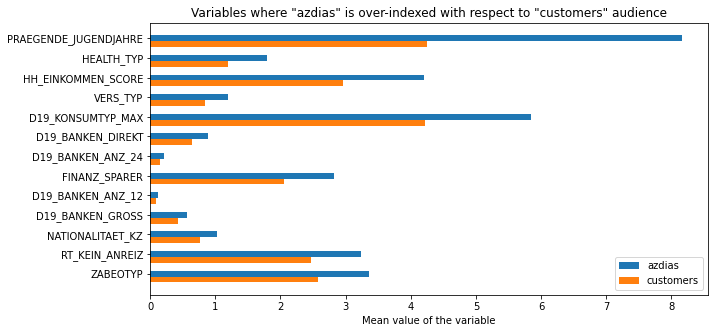

In [155]:
plt.figure(figsize = (10, 5))
plt.barh(y = np.arange(ft_diff1.shape[0]), width = ft_diff1['azdias'], height = 0.3, label = 'azdias')
plt.yticks(np.arange(ft_diff1.shape[0]), ft_diff1['var'])

plt.barh(y = np.arange(ft_diff1.shape[0]) - 0.3, width = ft_diff1['customers'], height = 0.3, label = 'customers')
plt.xlabel('Mean value of the variable')
plt.title('Variables where "azdias" is over-indexed with respect to "customers" audience')
plt.legend();

In [159]:
# ZABEOTYP - typification of energy consumers ("Azdias" are more price driven; while "customers" are more "green" driven)
# RT_KEIN_ANREIZ - 
# NATIONALITAET_KZ - nationaltity (scored by prename analysis) ("Azdias" have more proportion of foreigners, while "customers" are more German)
# D19_BANKEN_GROSS - transactional activity based on the product group BIG BANKS ("Azdias" has more transaction activity for "Big banks")
# D19_BANKEN_ANZ_12 - transaction activity BANKS in the last 12 months ("Azdias" have increased banking activity in the last 12 months compared to "customers")
# FINANZ_SPARER - financial typology: money saver ("Azdias" are low money savers, while "customers" are high money savers)
# D19_BANKEN_ANZ_24 - transaction activity BANKS in the last 24 months ("Azdias" have increased banking activity in the last 24 months much more than "customers")
# D19_BANKEN_DIREKT - transactional activity based on the product group DIRECT BANKS ("Azdias" has more transaction activity for "Direct Banks")
# D19_KONSUMTYP_MAX - 
# VERS_TYP - insurance typology ("Azdias" has more risky behavior than "customers")
# HH_EINKOMMEN_SCORE - estimated household net income ("Azdias" household income is lower than "customers")
# HEALTH_TYP - health typology ("Azdias" are less healthy than "customers")
# PRAEGENDE_JUGENDJAHRE - dominating movement in the person's youth (avantgarde or mainstream) ("Azdias" are younger than "customers")

In [161]:
# Variables where azdias is overindexing
ft_diff2 = ft[(ft['ratio'] <= 0.7)]
ft_diff2 = ft_diff2.sort_values('ratio')

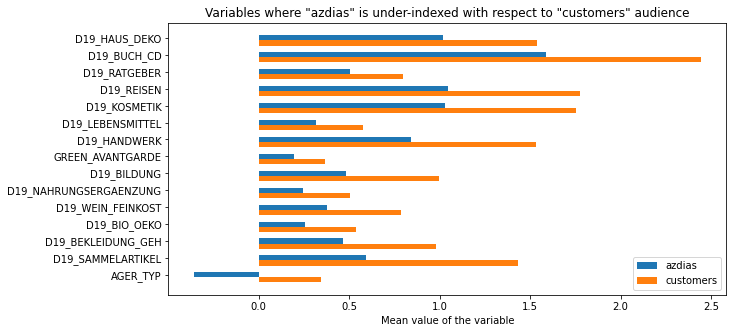

In [162]:
plt.figure(figsize = (10, 5))
plt.barh(y = np.arange(ft_diff2.shape[0]), width = ft_diff2['azdias'], height = 0.3, label = 'azdias')
plt.yticks(np.arange(ft_diff2.shape[0]), ft_diff2['var'])

plt.barh(y = np.arange(ft_diff2.shape[0]) - 0.3, width = ft_diff2['customers'], height = 0.3, label = 'customers')
plt.xlabel('Mean value of the variable')
plt.title('Variables where "azdias" is under-indexed with respect to "customers" audience')
plt.legend();

In [164]:
# AGER_TYP - best-ager typology (Age if "Azdias" is not well known, while age of "customers" is well known or elderly)
# D19_SAMMELARTIKEL - transactional activity based on the product group COLLECTABLE ITEMS ("Azdias" has less transaction activity for Collectable items)
# D19_BEKLEIDUNG_GEH - transactional activity based on the product group LUXURY CLOTHING ("Azdias" has less transaction activity for "Luxury" items)
# D19_BIO_OEKO - transactional activity based on the product group ECOLOGICALS ("Azdias" has less transaction activity for "Ecologicals")
# D19_WEIN_FEINKOST - transactional activity based on the product group WINE AND GOURMET FOOD ("Azdias" has less transaction activity for "Wine and Gourmet Foods")
# D19_NAHRUNGSERGAENZUNG - transactional activity based on the product group DIETARY SUPPLEMENTS ("Azdias" has less transaction activity for "Dietary supplements")
# D19_BILDUNG - transactional activity based on the product group EDUCATION ("Azdias" has less transaction activity for "Education" related products)
# GREEN_AVANTGARDE - the environmental sustainability is the dominating movement in the youth of these consumers ("Azdias" has less score for "Green avantgarde")
# D19_HANDWERK - transactional activity based on the product group DO-IT-YOURSELF PRODUCTS ("Azdias" has less transaction activity for "Do-it yourself" products)
# D19_LEBENSMITTEL - transactional activity based on the product group FOOD PRODUCTS ("Azdias" has less transaction activity for "Food products")
# D19_KOSMETIK - transactional activity based on the product group COSMETIC PRODUCTS ("Azdias" has less transaction activity for "Cosmetic" products)
# D19_REISEN - transactional activity based on the product group TRAVEL RELATED PRODUCTS ("Azdias" has less transaction activity for "Travel related products")
# D19_RATGEBER - transactional activity based on the product group GUIDEBOOKS ("Azdias" has less transaction activity for "Guidebooks")
# D19_BUCH_CD
# D19_HAUS_DEKO - transactional activity based on the product group HOUSE DECORATION ("Azdias" has less transaction activity for "House decoration" items)

In [163]:
ft_diff2

,var,azdias,customers,ratio
1,AGER_TYP,-0.358435,0.344359,-1.04088
43,D19_SAMMELARTIKEL,0.594606,1.43218,0.415175
19,D19_BEKLEIDUNG_GEH,0.467869,0.978727,0.478039
22,D19_BIO_OEKO,0.257938,0.538492,0.479001
68,D19_WEIN_FEINKOST,0.377515,0.788126,0.479003
40,D19_NAHRUNGSERGAENZUNG,0.244524,0.505917,0.483328
21,D19_BILDUNG,0.485508,0.998565,0.486206
78,GREEN_AVANTGARDE,0.196612,0.367171,0.535479
34,D19_HANDWERK,0.841994,1.53526,0.548439
39,D19_LEBENSMITTEL,0.319525,0.577636,0.553159


In [166]:
# Till now we have profied "Azdias" and "Customers" users using only numeric variables. Now, let's analyze them
# Now, let's look at the profiles of Azdias and Customers using character variables

In [167]:
comb_char.head(2)

,OST_WEST_KZ,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,source,CAMEO_DEUG_2015,EINGEFUEGT_AM,CAMEO_DEU_2015
0,NaN,NaN,NaN,azdias,NaN,NaN,NaN
1,W,51,NaN,azdias,8,1992-02-10 00:00:00,8A


In [313]:
list1 = list(comb_char.columns)
list1.remove('source')
list1.remove('EINGEFUEGT_AM')
list1

['OST_WEST_KZ',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

<ipython-input-319-d4b8b411b210>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_azdias['percent'] = d_azdias['count']/d_azdias['count'].sum()
<ipython-input-319-d4b8b411b210>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_customers['percent'] = d_customers['count']/d_customers['count'].sum()


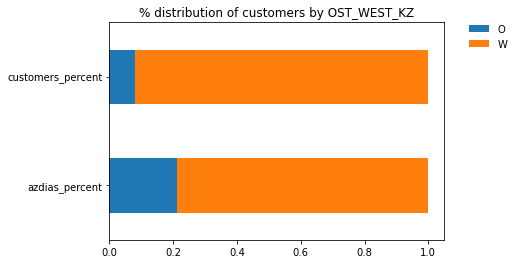

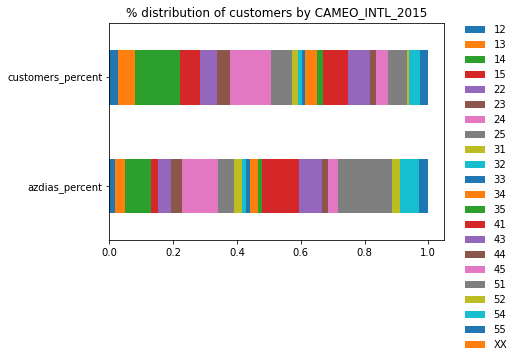

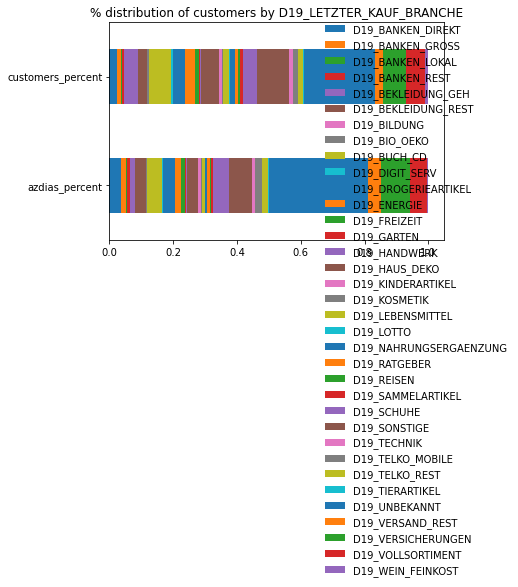

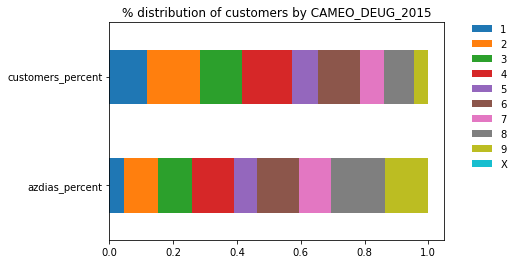

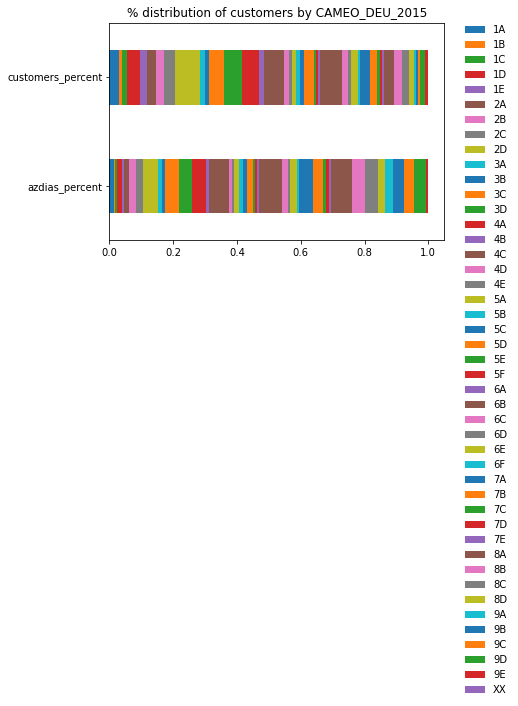

In [319]:
for i in list1:
    d = comb_char.groupby(['source', i]).size().reset_index()
    d = d.rename(columns = {d.columns[2]: 'count'})

    d_azdias = d[d['source'] == 'azdias']
    d_customers = d[d['source'] == 'customers']

    d_azdias['percent'] = d_azdias['count']/d_azdias['count'].sum()
    d_customers['percent'] = d_customers['count']/d_customers['count'].sum()

    d_az = d_azdias[[i, 'percent']]
    d_cust = d_customers[[i, 'percent']]

    d_az = d_az.rename(columns = {d_az.columns[1]: 'azdias_percent'})
    d_cust = d_cust.rename(columns = {d_cust.columns[1]: 'customers_percent'})

    d_az_cust = d_az.merge(d_cust, left_on = i, right_on = i, how = "outer")

    d1 = d_az_cust.transpose()

    d1.columns = d1.iloc[0]

    d1 = d1[1:]

    d1 = d1.reset_index()
    d1 = d1.rename(columns = {d1.columns[0]: 'segment'})

    m = i

    # plt.figure(figsize = (10, 10))
    d1.plot(kind = 'barh', stacked = True)
    # plt.xticks(np.arange(d1.shape[0]), d1['segment'])
    plt.yticks(np.arange(d1.shape[0]), d1['segment'])
    plt.title("% distribution of customers by {}".format(m))
    plt.legend(loc = "upper right", bbox_to_anchor=(1.2, 1.01), ncol = 1, borderaxespad=0, frameon=False);
    # plt.tight_layout();
    

In [320]:
# Based on these charts, the following obsevations can be made:
#     1. "Customers" have a higher proportion of users from "West (FRG)" compared to "Azdias"
#     2. "Customers" have a higher proportion of wealthy users compared to "Azdias"
#     3. "Customers" have a higher proportion of upper and upper middle class users compared to "Azdias"

In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [5]:
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [6]:
# train.shape

In [3]:
import pandas as pd
import numpy as np

In [4]:
# Importing data
# Ensuring that two variables are given the format of 'str' while importing to avoid warning
train = pd.read_csv('C:/Users/Prithvi/Downloads/Practice/Udacity/Arvato/mailout_train.csv',
                    dtype = {'CAMEO_DEUG_2015': str, 'CAMEO_INTL_2015': str})

In [5]:
train.shape

(42962, 368)

In [6]:
train.head(2)

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3


In [7]:
train = train.drop('Unnamed: 0', axis = 1)

In [8]:
train.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3


In [9]:
train.groupby('RESPONSE').count()['LNR']

RESPONSE
0    42430
1      532
Name: LNR, dtype: int64

In [10]:
# Response rate
(train.groupby('RESPONSE').count()['LNR'][1])/train.shape[0]

0.012383036171500396

In [11]:
# The response rate is very low

In [12]:
# Importing various binary classification libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

In [13]:
train.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3


In [14]:
# Taking variables which don't have more than 20% of their values as missing
# This can be done before train test split

In [15]:
train.shape

(42962, 367)

In [16]:
a = pd.DataFrame(train.isnull().sum()/train.shape[0]).reset_index()
a.columns = ['var', 'per_miss']
# a.head(3)

In [17]:
(a['per_miss'] <= 0.2).sum()

295

In [18]:
list1 = list(a[a['per_miss'] <= 0.2]['var'])

In [19]:
# Considering variables with a maximum 20% of their values as missing
train = train[list1]

In [20]:
train.shape

(42962, 295)

In [21]:
X = train.drop(['RESPONSE', 'LNR'], axis = 1)
y = train['RESPONSE']

In [22]:
X.shape

(42962, 293)

In [23]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_data = X.select_dtypes(include = numerics)

In [24]:
numeric_data.shape

(42962, 287)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [22]:
#Replacing missing values
#Replacing numeric missing values with mean
#Replacing character missing values with 'Missing'
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num = X_train.select_dtypes(include = numerics)

In [23]:
num_cols = list(num.columns)

In [24]:
char_vars = list(set(X_train.columns).difference(set(num.columns)))

In [25]:
char = X_train[char_vars]

In [26]:
num = num.fillna(num.mean())

In [27]:
scaler = MinMaxScaler()
num = scaler.fit_transform(num)

In [28]:
# Dropping the date variable
char = char.drop('EINGEFUEGT_AM', axis = 1)

In [29]:
#Replacing missing values with 'Missing'
char = char.fillna('Missing')

In [30]:
char = pd.get_dummies(char)

In [31]:
k = pd.DataFrame(num)
k.columns = num_cols

In [32]:
# Combining numeric and character variables again
X_train = pd.concat([k, char.reset_index(drop = True)], axis = 1)

In [33]:
X_train.shape

(34369, 406)

In [34]:
# Doing the same data manupulation on the test data
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num = X_test.select_dtypes(include = numerics)
num_cols = list(num.columns)

char_vars = list(set(X_test.columns).difference(set(num.columns)))
char = X_test[char_vars]
num = num.fillna(num.mean())

scaler = MinMaxScaler()
num = scaler.fit_transform(num)

# Dropping the date variable
char = char.drop('EINGEFUEGT_AM', axis = 1)

#Replacing missing values with 'Missing'
char = char.fillna('Missing')
char = pd.get_dummies(char)

k = pd.DataFrame(num)
k.columns = num_cols

X_test = pd.concat([k, char.reset_index(drop = True)], axis = 1)
# X_test = num

In [35]:
X_test.shape

(8593, 406)

#### Running first model using logistic regression

In [500]:
lr_model = LogisticRegression(max_iter = 200)
lr_model.fit(X_train, y_train)

C:\Users\Prithvi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

In [501]:
lr_model

LogisticRegression(max_iter=200)

In [503]:
pred = lr_model.predict_proba(X_train)[:,1]
roc_auc_score(y_train, pred)

0.8135309550690938

In [504]:
pred = lr_model.predict(X_train)
roc_auc_score(y_train, pred)

0.5

In [505]:
pred = lr_model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, pred)

0.6798554246292932

In [176]:
# AUROC curveof 67% is achieved on test data using logisic regression
# This can be our base model, and let's try to improve on this

#### Let's build next model using Random Forest

In [506]:
from sklearn.ensemble import RandomForestClassifier

In [507]:
rf_model = RandomForestClassifier()

In [508]:
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [509]:
len(rf_model.feature_importances_)

406

In [521]:
pd.DataFrame(pd.Series(rf_model.feature_importances_, index = X_train.columns).sort_values(ascending = False)).head(5)
# pd.DataFrame(pd.Series(rf_model.feature_importances_).sort_values(ascending = False)).head(4)

,0
KBA13_ANZAHL_PKW,0.011850
GFK_URLAUBERTYP,0.008746
ONLINE_AFFINITAET,0.008235
LP_LEBENSPHASE_FEIN,0.007840
CJT_GESAMTTYP,0.006815


In [511]:
# On train data

In [512]:
pred = rf_model.predict_proba(X_train)[:,1:]
roc_auc_score(y_train, pred)

0.9792311648010597

In [513]:
pred = rf_model.predict(X_train)
roc_auc_score(y_train, pred)

0.9362606232294617

In [514]:
metrics.confusion_matrix(y_train, pred)

array([[28431,     0],
       [   45,   308]], dtype=int64)

In [515]:
#On Test data

In [516]:
pred = rf_model.predict_proba(X_test)[:,1:]
roc_auc_score(y_test, pred)

0.6270048818331397

In [ ]:
# 62% AUROC is achieved here

In [517]:
pred = rf_model.predict(X_test)
roc_auc_score(y_test, pred)

0.5

In [518]:
metrics.confusion_matrix(y_test, pred)

array([[13999,     0],
       [  179,     0]], dtype=int64)

#### Build several models using various classification techniques. The technique which gives the best AUROC values can be explored further

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
import time

In [58]:
models = {
        'LogisticRegression': LogisticRegression(max_iter = 500),
          'RandomForest': RandomForestClassifier(),
         'DecisionTree': DecisionTreeClassifier(),
         'SVM': svm.SVC(probability = True),
         'GradientBoostedTree': GradientBoostingClassifier(),
         'xgboost': XGBClassifier(use_label_encoder = False),
         'NeuralNetwork': MLPClassifier(),
          'KNearestNeighbor': KNeighborsClassifier(),
          'NaiveBayes': GaussianNB(),
          'StochasticGradientDescent': SGDClassifier(loss = 'log'),
          'AdaBoost': AdaBoostClassifier(),
          'LightGBM': LGBMClassifier()              #-- try dart in hyperparamter for better accuracy
         }

# During GridSearchCV use n_jobs = 8 or 4 for parallelization otherwise by default only 1 cpu is used

In [59]:
l = []
for i in models:
    d = {}
    start = time.time()
    model = models[i]
    model.fit(X_train, y_train)

    pred = model.predict_proba(X_train)[:,1:]
    train_roc = round(roc_auc_score(y_train, pred), 2)

    pred = model.predict_proba(X_test)[:,1:]
    test_roc = round(roc_auc_score(y_test, pred), 2)
    end = time.time()
    duration = round(end - start)
    print(i, "training_AUROC:", train_roc, "testing_AUROC:", test_roc, "Timetaken:", duration)
    d['method'] = model
    d['training_AUROC'] = train_roc
    d['testing_AUROC'] = test_roc
    d['duration'] = duration
    l.append(d)

LogisticRegression training_AUROC: 0.81 testing_AUROC: 0.68 Timetaken: 13
RandomForest training_AUROC: 0.98 testing_AUROC: 0.6 Timetaken: 16
DecisionTree training_AUROC: 0.99 testing_AUROC: 0.49 Timetaken: 4
SVM training_AUROC: 0.97 testing_AUROC: 0.59 Timetaken: 2612
GradientBoostedTree training_AUROC: 0.91 testing_AUROC: 0.75 Timetaken: 122
[09:06:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgboost training_AUROC: 0.99 testing_AUROC: 0.68 Timetaken: 21
NeuralNetwork training_AUROC: 0.99 testing_AUROC: 0.55 Timetaken: 141
KNearestNeighbor training_AUROC: 0.91 testing_AUROC: 0.5 Timetaken: 2358
NaiveBayes training_AUROC: 0.59 testing_AUROC: 0.56 Timetaken: 1
StochasticGradientDescent training_AUROC: 0.79 testing_AUROC: 0.69 Timetak

In [60]:
perf = pd.DataFrame(l)

In [66]:
# Sorting by AUROC value
perf.sort_values(by = 'testing_AUROC', ascending = False)

,method,training_AUROC,testing_AUROC,duration
4,([DecisionTreeRegressor(criterion='friedman_ms...,0.91,0.75,122
10,"(DecisionTreeClassifier(max_depth=1, random_st...",0.84,0.73,34
9,SGDClassifier(loss='log'),0.79,0.69,2
11,LGBMClassifier(),0.99,0.69,3
0,LogisticRegression(max_iter=500),0.81,0.68,13
5,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.99,0.68,21
1,"(DecisionTreeClassifier(max_features='auto', r...",0.98,0.60,16
3,SVC(probability=True),0.97,0.59,2612
8,GaussianNB(),0.59,0.56,1
6,MLPClassifier(),0.99,0.55,141


In [177]:
# So, the best performance is given by GBT. 
# So, we will try to improve these models using hyperparamter tuning

In [37]:
X_train.head(2)

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_Missing,CAMEO_DEUG_2015_X
0,0.0,0.064722,0.490415,0.394345,0.015159,0.002455,0.015071,0.084004,0.016848,0.00496,...,0,0,0,0,0,0,0,0,1,0
1,0.0,1.000000,0.000000,0.000000,0.002283,0.000000,0.000000,0.125000,0.002710,0.00000,...,1,0,0,0,0,0,0,0,0,0


In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [74]:
rscv = RandomizedSearchCV(GradientBoostingClassifier(), 
                    scoring = 'roc_auc',
            param_distributions = {
                'learning_rate': [0.01, 0.005],
                'n_estimators': [200, 300, 500],
                'max_depth': [5, 6, 7],
                'subsample': [0.4, 0.5, 0.6, 0.7],
                'min_samples_leaf': [1, 2, 3, 4, 5],
                'min_samples_split': [2, 3, 4, 5]
            },
            cv = 5,
                          n_iter = 10
                    )

In [75]:
rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(),
                   param_distributions={'learning_rate': [0.01, 0.005],
                                        'max_depth': [5, 6, 7],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': [2, 3, 4, 5],
                                        'n_estimators': [200, 300, 500],
                                        'subsample': [0.4, 0.5, 0.6, 0.7]},
                   scoring='roc_auc')

In [76]:
per = pd.DataFrame(rscv.cv_results_)

In [78]:
per[['params', 'mean_test_score', 'rank_test_score']].sort_values(by = 'rank_test_score').head(6)

,params,mean_test_score,rank_test_score
5,"{'subsample': 0.4, 'n_estimators': 300, 'min_s...",0.772169,1
7,"{'subsample': 0.6, 'n_estimators': 500, 'min_s...",0.770521,2
9,"{'subsample': 0.5, 'n_estimators': 200, 'min_s...",0.770059,3
4,"{'subsample': 0.7, 'n_estimators': 300, 'min_s...",0.769989,4
8,"{'subsample': 0.4, 'n_estimators': 200, 'min_s...",0.768258,5
1,"{'subsample': 0.7, 'n_estimators': 300, 'min_s...",0.767623,6


In [79]:
rscv.best_estimator_

GradientBoostingClassifier(learning_rate=0.005, max_depth=6, min_samples_leaf=3,
                           min_samples_split=4, n_estimators=300,
                           subsample=0.4)

In [80]:
rscv.best_params_

{'subsample': 0.4,
 'n_estimators': 300,
 'min_samples_split': 4,
 'min_samples_leaf': 3,
 'max_depth': 6,
 'learning_rate': 0.005}

In [81]:
rscv.best_score_

0.7721691788538305

In [82]:
rscv.predict_proba(X_test)

array([[0.97047535, 0.02952465],
       [0.99587048, 0.00412952],
       [0.99584028, 0.00415972],
       ...,
       [0.98885884, 0.01114116],
       [0.99530692, 0.00469308],
       [0.9892312 , 0.0107688 ]])

In [ ]:
# AUROC of 77% is achived using RandomSearchCV using GradientBoostedTree Classifier

In [51]:
# gscv = GridSearchCV(GradientBoostingClassifier(), 
#                     scoring = 'roc_auc',
#             param_grid = {
#                 'learning_rate': [0.01, 0.005],
#                 'n_estimators': [200, 300, 500],
#                 'max_depth': [5, 6, 7],
#                 'subsample': [0.4, 0.5, 0.6, 0.7],
#                 'min_samples_leaf': [1, 2, 3, 4, 5],
#                 'min_samples_split': [2, 3, 4, 5]
#             },
#             cv = 5)

In [84]:
# gscv.fit(X_train, y_train)
# We will skip running the gridsearchcv as it is taking very loss to run

In [65]:
pd.set_option('display.max_colwidth', 50)

In [86]:
pred = rscv.predict_proba(X_train)[:,1:]
train_roc = roc_auc_score(y_train, pred)

In [87]:
pred = rscv.predict_proba(X_test)[:,1:]
test_roc = roc_auc_score(y_test, pred)

In [88]:
train_roc

0.9475547939640337

In [89]:
test_roc

0.7581069190488456

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
# mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [139]:
# Importing test data
test = pd.read_csv('C:/Users/Prithvi/Downloads/Practice/Udacity/Arvato/mailout_test.csv',
                    dtype = {'CAMEO_DEUG_2015': str, 'CAMEO_INTL_2015': str})

In [140]:
test.shape

(42833, 367)

In [141]:
test.head(2)

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4


In [142]:
# Data preparation steps
test = test.drop('Unnamed: 0', axis = 1)

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num = test.select_dtypes(include = numerics)

num_cols = list(num.columns)


char_vars = list(set(test.columns).difference(set(num.columns)))

char = test[char_vars]

num = num.fillna(num.mean())

scaler = MinMaxScaler()
num = scaler.fit_transform(num)

# Dropping the date variable
char = char.drop('EINGEFUEGT_AM', axis = 1)

#Replacing missing values with 'Missing'
char = char.fillna('Missing')

char = pd.get_dummies(char)

k = pd.DataFrame(num)
k.columns = num_cols

# Combining numeric and character variables again
test = pd.concat([k, char.reset_index(drop = True)], axis = 1)

In [143]:
X_train.head(2)

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_Missing,CAMEO_DEUG_2015_X
0,0.0,0.064722,0.490415,0.394345,0.015159,0.002455,0.015071,0.084004,0.016848,0.00496,...,0,0,0,0,0,0,0,0,1,0
1,0.0,1.000000,0.000000,0.000000,0.002283,0.000000,0.000000,0.125000,0.002710,0.00000,...,1,0,0,0,0,0,0,0,0,0


In [144]:
test[X_train.columns].shape

(42833, 406)

In [146]:
X_train.shape

(34369, 406)

In [147]:
test.shape

(42833, 479)

In [148]:
test.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_Missing,CAMEO_DEUG_2015_X
0,0.020421,0.75,0.0,0.333333,0.658377,0.710161,0.703566,0.60114,0.24,0.005277,...,1,0,0,0,0,0,0,0,0,0
1,0.020608,0.00,0.0,0.000000,0.658377,0.710161,0.703566,0.60114,0.00,0.052770,...,0,0,0,1,0,0,0,0,0,0


In [149]:
test1 = test[X_train.columns]

In [150]:
test1.shape

(42833, 406)

In [151]:
test1.head(2)

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_Missing,CAMEO_DEUG_2015_X
0,0.75,0.0,0.333333,0.24,0.005277,0.0,0.0,0.142857,0.005333,0.0,...,1,0,0,0,0,0,0,0,0,0
1,0.00,0.0,0.000000,0.00,0.052770,0.0,0.0,0.071429,0.056000,0.0,...,0,0,0,1,0,0,0,0,0,0


In [178]:
# Running predictions on the test data

In [152]:
predictions = rscv.predict_proba(test1)

In [153]:
# Importing the test data again to add the customer id - LNR - columns
test = pd.read_csv('C:/Users/Prithvi/Downloads/Practice/Udacity/Arvato/mailout_test.csv',
                    dtype = {'CAMEO_DEUG_2015': str, 'CAMEO_INTL_2015': str})
test = test.drop('Unnamed: 0', axis = 1)

In [154]:
test.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4


In [155]:
test.tail(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
42831,67949,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,1.0,4.0,4.0,2.0,6.0,9.0,3.0,3,2,3
42832,68898,-1,1.0,14.0,NaN,NaN,NaN,NaN,14.0,1.0,...,2.0,1.0,1.0,1.0,4.0,9.0,4.0,3,2,3


In [156]:
# probability to response (1) is given by the 2nd column in predictions
prob_resp = predictions[:,1]

In [157]:
prob_resp.shape

(42833,)

In [158]:
test['RESPONSE'] = prob_resp

In [159]:
test.shape

(42833, 367)

In [160]:
test.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,RESPONSE
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4,0.030982
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4,0.020897


In [161]:
final = test[['LNR', 'RESPONSE']]

In [162]:
final.shape

(42833, 2)

In [163]:
final.head(2)

,LNR,RESPONSE
0,1754,0.030982
1,1770,0.020897


In [164]:
final.to_csv('final.csv', index = False)

In [ ]:
# This will be uploaded to Kaggle page:
#     https://www.kaggle.com/c/udacity-arvato-identify-customers
        